# Data analysis - Introduction for FYSC12 Labs

## Table of Content

* [About this Notebook](#about)

* [Importing python packages](#import)

* [Read experimental data from file](#read)
    * [Analysis Code](#help1)
    * [Plotting the data](#plot)


* [Fit of data](#fit)
    * [Fitting Gaussians](#gaussian)
    * [Calculate Peak Area](#peak_area)
    * [Fit a line - Energy calibration](#line)


* [Statistical analysis - Error propagation](#stat)

## About this Notebook <a name="about"></a>

The purpose of this _jupyter_ notebook is to introduce data analysis in the
frame of gamma spectroscopy. The example programming language is _Python3_, but
of course most coding languages can do the job properly. If you have never
programmed before there are so many great tutorials available across the web.
There even exist plenty _Open Online Courses_, e.g.
https://www.coursera.org/learn/python. Please have a look around for the one
that you like the best. However, note that you do not need to be an expert in
Python to pass the lab.

The data analysis can roughly be divided into four steps:
1. Read experimental data from file.
2. Fit Gaussians to peaks.
3. Calibrate the detector response.
4. Perform a statistical analysis (e.g. error propagation) and present results.

A dedicated python library, i.e. a folder with already written code, located in
`HelpCode`, have been implemented for the data analysis connected to the labs in
FYSC12 Nuclear Physics. The folder comprises functions that support 1-3 of the
above-mentioned steps.

Full Python3 coding examples of how to perform the different steps of the data
analysis is given below. Every example is finished with a template of how the
`HelpCode`-folder can be used to perform the same calculations.

**NOTE**: It is strongly recommended that you program your own functions instead
of using the framework directly out of the book. As you will find out, there
will come a point where the framework functionalities are not to your
satisfaction, and then you need to code yourself. So, better get used to it
right away :)

## Importing python packages <a name="import"></a>

Inserting parent directory to the path such that the analysis code in `fithelpers.py`, `histhelpers.py` and `MCA.py` can be found by `python`.

In [1]:
import sys, os
sys.path.append('../')
import numpy as np
import fithelpers, histhelpers, MCA

## Read experimental data from file <a name="read"></a>

For an introduction on how to read and write files see e.g. http://www.pythonforbeginners.com/files/reading-and-writing-files-in-python or you could have a look at the source code in [MCA.py](../MCA.py).

### Analysis Code <a name="help1"></a>

With the `analysis_code` one can read the experimental data from one data file as follows:

In [2]:
data = MCA.load_spectrum("test_data.Spe")

`data` is an object of a class `Spectrum` and holds the channels in `x` and its content in `y` (cf. [MCA.py](../MCA.py)). See for instance: 

In [3]:
print('x = ', data.x)
print('y = ', data.y)

x =  [   0    1    2 ... 8189 8190 8191]
y =  [0. 0. 0. ... 0. 0. 0.]


### Plotting the data <a name="plot"></a>

It is always good to visualise your data. This is how you can plot and visualise it:

In [4]:
import matplotlib
# choose a backend for web applications; remove for stand-alone applications:
matplotlib.use('Agg')
# enable interactive notebook plots (
# alternative: use 'inline' instead of 'notebook'/'widget' for static images)
%matplotlib notebook

#The following line is the ONLY one needed in stand-alone applications!
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


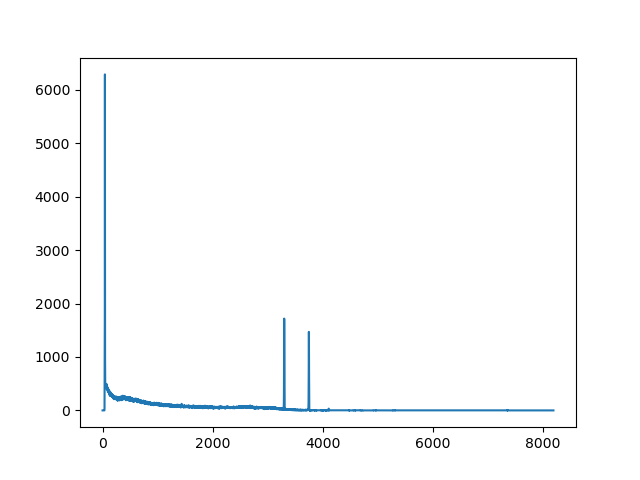

In [5]:
plt.figure()
# with the data read in with the first routine
plt.plot(data.x, data.y)

#plt.savefig("test_spectrum.png") #This is how you save the figure
plt.show()

## Could be useful to see this in log scale..?
#plt.yscale('log')
#plt.ylim(ymin=1)

## Fit of data <a name="fit"></a>

Fitting functions can be made simply with the `scipy.optimize` module. The
function `curve_fit` does the job for you and the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) contains
all the valuable information on how to use the function. It uses a method called
least squares which you can read about in most course literature on statistics
and for instance on [Wolfram
Alpha](http://mathworld.wolfram.com/LeastSquaresFitting.html).

### Fitting Gaussian <a name="gaussian"></a>

Read up on the Gaussian function here: [https://en.wikipedia.org/wiki/Gaussian_function](https://en.wikipedia.org/wiki/Gaussian_function)

The following code shows how to use the function `curve_fit` to fit a peak in
the data that was read in above (i.e. you will need to execute the above code
section before this section will work).

Estimates of (A mu sigma) = ( 1701.437969921561 3300.173963396903 2.690782635538004 )

Covariance matrix = 
 [[ 2.22927047e+02  4.29594398e-06 -2.35037636e-01]
 [ 4.29594398e-06  7.43418433e-04 -6.79408923e-09]
 [-2.35037636e-01 -6.79408923e-09  7.43418426e-04]] 

Uncertainties in the estimated parameters: 
[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = 
[ 222.92704699299122 0.0007434184333430844 0.0007434184263502239 ]


<IPython.core.display.Javascript object>


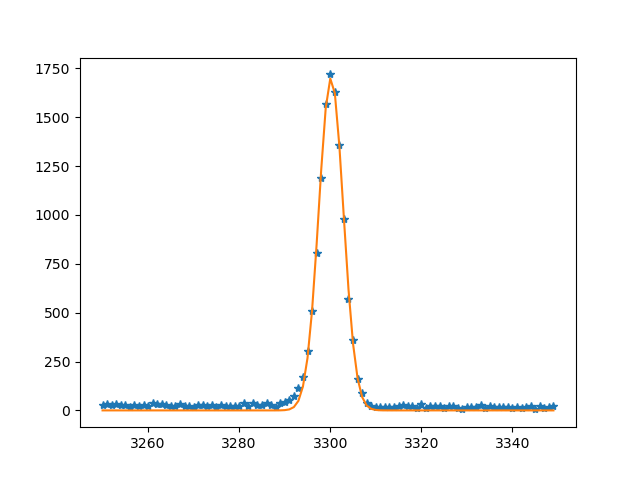

In [6]:
from scipy.optimize import curve_fit

def GaussFunc(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

#mu = np.asarray([3300, 3750])
#E = np.asarray([1173.2, 1332.5])
mu_guess = 3300
A_guess = data.y[mu_guess]
sigma_guess = 1
guess = [A_guess, mu_guess, sigma_guess]
n = 50 #number of points on each side to include in fit

estimates, covar_matrix = curve_fit(GaussFunc,
                                    data.x[mu_guess-n:mu_guess+n],
                                    data.y[mu_guess-n:mu_guess+n],
                                    p0=guess)
A, mu, sigma = estimates[0], estimates[1], estimates[2]
print("Estimates of (A mu sigma) = (", A, mu, sigma, ")\n")

print("Covariance matrix = \n", covar_matrix, "\n")

print("Uncertainties in the estimated parameters: \n[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = \n[", covar_matrix[0][0], covar_matrix[1][1], covar_matrix[2][2], "]" )

plt.figure()
plt.plot(data.x[mu_guess-n:mu_guess+n],data.y[mu_guess-n:mu_guess+n], linestyle="", marker="*")
plt.plot(data.x[mu_guess-n:mu_guess+n], GaussFunc(data.x[mu_guess-n:mu_guess+n], A, mu, sigma))
plt.show()

### Calculating Peak Area <a name="peak_area"></a>

There are different ways in how to calculate the area of a peak in a spectrum. The by far easiest method is to calculate the area of the fitted Gaussian function (see [https://en.wikipedia.org/wiki/Gaussian_function](https://en.wikipedia.org/wiki/Gaussian_function)).

In [7]:
Area = np.sqrt(2*np.pi)*A*np.abs(sigma)
print('Area of peak is: ', Area)

Area of peak is:  11475.844927499762


### Analysis code

With the analysis code:

Estimates of (A mu sigma) = ( 1701.437969921561 3300.173963396903 2.690782635538004 )

Covariance matrix = 
 [[ 2.22927047e+02  4.29594398e-06 -2.35037636e-01]
 [ 4.29594398e-06  7.43418433e-04 -6.79408923e-09]
 [-2.35037636e-01 -6.79408923e-09  7.43418426e-04]] 

Uncertainties in the estimated parameters: 
[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = 
[ 222.92704699299122 0.0007434184333430844 0.0007434184263502239 ]


<IPython.core.display.Javascript object>


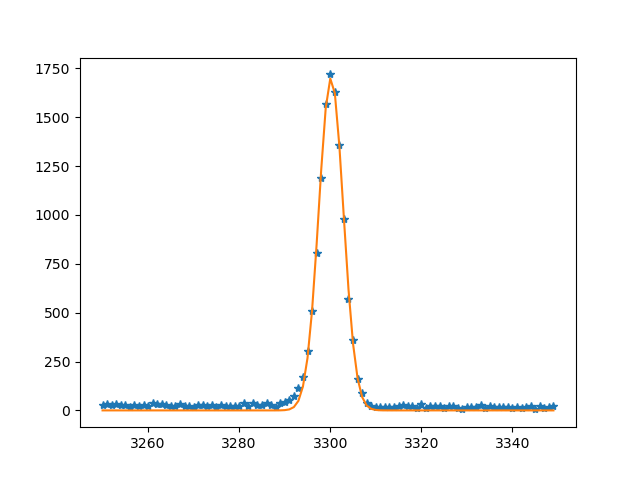

Area of peak is:  11475.844927499762


In [8]:
mu_guess = 3300
A_guess = data.y[mu_guess]
sigma_guess = 1
n = 50 #number of points on each side to include in fit

gauss = fithelpers.fit_gaussian_at_idx(data.x, data.y, mu_guess, npoints=n)
print("Estimates of (A mu sigma) = (", gauss.A, gauss.mu, gauss.sigma, ")\n")

print("Covariance matrix = \n", gauss.covar_matrix, "\n")

print("Uncertainties in the estimated parameters: \n[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = \n[", gauss.covar_matrix[0][0], gauss.covar_matrix[1][1], gauss.covar_matrix[2][2], "]" )

plt.figure()
plt.plot(data.x[mu_guess-n:mu_guess+n], data.y[mu_guess-n:mu_guess+n], linestyle="", marker="*")
plt.plot(data.x[mu_guess-n:mu_guess+n], gauss.value(data.x)[mu_guess-n:mu_guess+n])
plt.show()

Area = np.sqrt(2*np.pi)*gauss.A*np.abs(gauss.sigma)
print('Area of peak is: ', Area)

### Fit a line - Energy calibration <a name="line"></a>

In spectroscopy experiments it is often essential to calibrate the detector response with respect to a known energies emitted from a so called calibration source. The relationship between the detector response and the energy is mostly assumed linear. The code below exemplifies how to estimate the linear calibration for 'random data'.

Estimates of (k m) = ( 0.51544342764661 0.4022935634807532 )



<IPython.core.display.Javascript object>


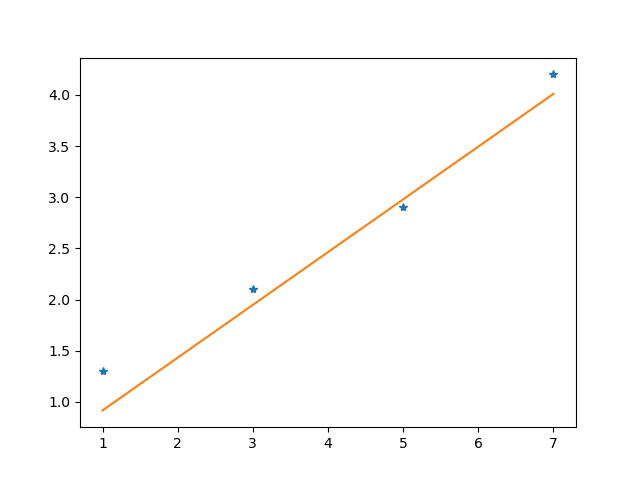

In [9]:
# x and y are some 'random data'
x = np.asarray([1,3,5,7])
y = np.asarray([1.3, 2.1, 2.9, 4.2])

#If you are more or less uncertain about your y-values this can be used in the fit by including the following line.
sigmay = np.asarray([0.5, 0.3, 0.1, 0.2])

# Define the linear function which you want to fit.
def LineFunc(x, k, m):
    return k*x+m

# As for the Gaussian fit the function curve_fit needs a guess for the parameters to be estimated.
guess = [2, 1]

# Perform the fit
estimates, covar_matrix = curve_fit(LineFunc,
                                    x,
                                    y,
                                    p0 = guess,
                                    sigma = sigmay)

print("Estimates of (k m) = (", estimates[0], estimates[1], ")\n")

# plot the result
plt.figure()
plt.plot(x,y, linestyle="", marker="*")
plt.plot(x, LineFunc(x, estimates[0], estimates[1]))
plt.show()

## Statistical analysis - Error propagation<a name="stat"></a>

Background theory and instructions on how to perform statistical analysis on
experimental data, with error propagation, can be found in the document
http://www.fysik.lu.se/fileadmin/fysikportalen/UDIF/Bilder/FYSA31_KF_error.pdf, but of course also easily through a google search.